# Basic Exploratory Data Analysis On Entire Dataset

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import mysql.connector
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices
from pandas.core import datetools
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelBinarizer
from sklearn.cluster import KMeans

sns.set_style('darkgrid')
pd.options.display.float_format = '{:,.2f}'.format
pd.options.display.max_columns = None

/home/gspc/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
def create_connection():
    cnx2 = mysql.connector.connect(host='localhost',
                                   user='root', password='MyNewPass',
                                   database='Weather_Data')
    return cnx2

In [3]:
def select_data():
    conn = create_connection()
    cursor = conn.cursor()
    print('Extracting Data')
    query = "Select * from weather where Observation_date <= '2018-06-01 00:00:00';"
    cursor.execute(query, )
    result = cursor.fetchall()
    print('Extracted Data')
        
    cursor.close()
    conn.close()
    
    return result
    

In [4]:
def null_values(data):
    print(data.isnull().sum())

In [5]:
def change_structure(data):
    cols = ['date', 'rain', 'temp', 'wetb', 'dewpt','vappr', 'rhum', 'msl', 'wdsp', 'wddir','height','latitude', 'longitude', 'station','county']
    data = pd.DataFrame(data, columns=cols)
    
    null_values(data)
    data.fillna(0, inplace=True)
    return data

In [6]:
def split_time(data):
    data['date'] = pd.to_datetime(data['date'])
    data['year'] = data['date'].dt.year
    data['month'] = data['date'].dt.month.astype(np.uint8)
    data['day'] = data['date'].dt.day.astype(np.uint8)
    data['hour'] = data['date'].dt.hour.astype(np.uint8)
    
    return data

In [7]:
def generate_season(data):
    data['season'] = pd.cut(data['month'], bins=[0,1,4,7,10,14], labels=['Winter','Spring','Summer','Autumn','Winter2']).str.replace('Winter2','Winter')
    #data['season'] = data['season'].astype('category')
    return data

In [8]:
def convert_wdsp(data):
    data['wdsp'] = data['wdsp'] * 1.852
    
    return data

In [9]:
def mean_features(data):
    # mean rain, temp, windsp, windirection by year, by season
    group = ['year', 'season','month','station']
    features = ['rain', 'temp', 'wdsp', 'wddir','wetb', 'dewpt','vappr', 'rhum', 'msl']
    
    for grouping in group:
        for predictor in features:
            print('Grouping by ',grouping, ' getting average ', predictor )
            
            new_var = predictor + '_by_' + grouping
            temp = data.groupby(grouping)[predictor].mean().reset_index() 
            temp.columns = [grouping, new_var]
            data = data.merge(temp, how='left', on=grouping)
    
    null_values(data)
    
    return data

In [10]:
def remove_rhum_values(data):
    print('Removing relative humidity values <= 0')
    data = data[data['rhum'] > 0]
    
    return data

In [11]:
def update_rhum_values(data):
    print('Updating relative humidity values <= 0')
    rhum_mean = data['rhum'].mean()
    data.loc[data['rhum'] <= 0, 'rhum'] = rhum_mean
    
    return data

In [12]:
def update_wetb_values(data):
    print('Updating wet bulb air temperature values <= 0')
    wetb_mean = data['wetb'].mean()
    data.loc[data['wetb'] <= -40, 'wetb'] = wetb_mean
    
    return data

In [13]:
def update_dewpt_values(data):
    print('Updating dew point air temperature values <= 0')
    dewpt_mean = data['dewpt'].mean()
    data.loc[data['dewpt'] <= -20,'dewpt'] = dewpt_mean
    
    return data

In [14]:
def update_msl_values(data):
    print('Updating mean sea level pressure values <= 0')
    msl_mean = data['msl'].mean() 
    data.loc[data['msl'] < 940, 'msl'] = msl_mean
    
    return data

In [15]:
def update_vappr_values(data):
    print('Updating vapour pressure values <= 0')
    vappr_mean = data['vappr'].mean()
    data.loc[data['vappr'] <= 0, 'vappr'] = vappr_mean
    
    return data

In [16]:
def remove_msl_values(data):
    print('Removing mean sea level pressure values < 940')
    data = data[data['msl'] >= 940]
    
    return data

In [17]:
def remove_vappr_values(data):
    print('Removing vapour pressure values <= 0')
    data = data[data['vappr'] > 0]
    
    return data

In [18]:
def plot_by_year(data):
    data = data.sort_values('year')
    
    plt.figure(figsize=(15,55))
    plt.suptitle('Yearly Averages')
    
    plt.subplot(521)
    plt.scatter('year', 'rain_by_year', data=data, color="orange")
    plt.xticks(np.arange(data['year'].min(), data['year'].max()) )
    plt.xlabel('Year', fontweight='bold', color = 'orange', fontsize='14')
    plt.ylabel('Average Rainfall by Year', fontweight='bold', color = 'orange', fontsize='14')
    plt.xticks(rotation=75)
    plt.title('Average Yearly Rainfall Distribution')
    
    plt.subplot(522)
    plt.scatter('year', 'temp_by_year', data=data, color="green")
    plt.xticks(np.arange(data['year'].min(), data['year'].max()) )
    plt.xlabel('Year', fontweight='bold', color = 'orange', fontsize='14')
    plt.ylabel('Average Temperature by Year', fontweight='bold', color = 'orange', fontsize='14')
    plt.xticks(rotation=75)
    plt.title('Average Yearly Temperature Distribution')

    
    plt.subplot(523)
    plt.scatter('year', 'wdsp_by_year', data=data, color="blue")
    plt.xticks(np.arange(data['year'].min(), data['year'].max()) )
    plt.xlabel('Year', fontweight='bold', color = 'orange', fontsize='14')
    plt.ylabel('Average Windspeed by Year', fontweight='bold', color = 'orange', fontsize='14')
    plt.xticks(rotation=75)
    plt.title('Average Yearly Windspeed Distribution')

    
    plt.subplot(524)
    plt.scatter('year', 'wddir_by_year', data=data, color="red")
    plt.xticks(np.arange(data['year'].min(), data['year'].max()) )
    plt.xlabel('Year', fontweight='bold', color = 'orange', fontsize='14')
    plt.ylabel('Average Wind Direction by Year', fontweight='bold', color = 'orange', fontsize='14')
    plt.xticks(rotation=75)
    plt.title('Average Yearly Wind Direction Distribution')
    
    plt.subplot(525)
    plt.scatter('year', 'wetb_by_year', data=data, color="orange")
    plt.xticks(np.arange(data['year'].min(), data['year'].max()) )
    plt.xlabel('Year', fontweight='bold', color = 'orange', fontsize='14')
    plt.ylabel('Average Wet Bulb Temp by Year', fontweight='bold', color = 'orange', fontsize='14')
    plt.xticks(rotation=75)
    plt.title('Average Wet Bulb Temp Distribution')
    
    plt.subplot(526)
    plt.scatter('year', 'dewpt_by_year', data=data, color="red")
    plt.xticks(np.arange(data['year'].min(), data['year'].max()) )
    plt.xlabel('Year', fontweight='bold', color = 'orange', fontsize='14')
    plt.ylabel('Average Dew Point Temp by Year', fontweight='bold', color = 'orange', fontsize='14')
    plt.xticks(rotation=75)
    plt.title('Average Dew Point Temp Distribution')
    
    plt.subplot(527)
    plt.scatter('year', 'vappr_by_year', data=data, color="blue")
    plt.xticks(np.arange(data['year'].min(), data['year'].max()) )
    plt.xlabel('Year', fontweight='bold', color = 'orange', fontsize='14')
    plt.ylabel('Average Vapour Pressure by Year', fontweight='bold', color = 'orange', fontsize='14')
    plt.xticks(rotation=75)
    plt.title('Average Vapour Pressure Distribution')
    
    plt.subplot(528)
    plt.scatter('year', 'rhum_by_year', data=data, color="green")
    plt.xticks(np.arange(data['year'].min(), data['year'].max()) )
    plt.xlabel('Year', fontweight='bold', color = 'orange', fontsize='14')
    plt.ylabel('Average Relative Humidity by Year', fontweight='bold', color = 'orange', fontsize='14')
    plt.xticks(rotation=75)
    plt.title('Average Relative Humidity Distribution')
    
    plt.subplot(529)
    plt.scatter('year', 'msl_by_year', data=data, color="red")
    plt.xticks(np.arange(data['year'].min(), data['year'].max()) )
    plt.xlabel('Year', fontweight='bold', color = 'orange', fontsize='14')
    plt.ylabel('Average Mean Sea Level Pressure by Year', fontweight='bold', color = 'orange', fontsize='14')
    plt.xticks(rotation=75)
    plt.title('Average Sea Level Pressure Distribution')

    
    plt.savefig('Yearly Averages.png')

    
    plt.show()

In [19]:
def plot_by_season(data):
    data['season'] = data['season'].astype('category')
    data['season'].cat.reorder_categories(['Spring', 'Summer','Autumn', 'Winter'], inplace=True)
    data = data.sort_values('season').reset_index()
    
    plt.figure(figsize=(15,55))
    plt.suptitle('Season Averages')
    
    plt.subplot(521)
    sns.barplot(x="season", y="rain_by_season", data=data);
    plt.xlabel('Season', fontweight='bold', color = 'orange', fontsize='14')
    plt.ylabel('Average Rainfall', fontweight='bold', color = 'orange', fontsize='14')
    plt.title('Average Rainfall by Season')
    
    plt.subplot(522)
    sns.barplot(x="season", y="temp_by_season", data=data);
    plt.xlabel('Season', fontweight='bold', color = 'orange', fontsize='14')
    plt.ylabel('Average Temperature', fontweight='bold', color = 'orange', fontsize='14')
    plt.title('Average Temperature by Season')

    
    plt.subplot(523)
    sns.barplot(x="season", y="wdsp_by_season", data=data);
    plt.xlabel('Season', fontweight='bold', color = 'orange', fontsize='14')
    plt.ylabel('Average Windspeed', fontweight='bold', color = 'orange', fontsize='14')
    plt.title('Average Windspeed by Season')

    
    plt.subplot(524)
    sns.barplot(x="season", y="wddir_by_season", data=data);
    plt.xlabel('Season', fontweight='bold', color = 'orange', fontsize='14')
    plt.ylabel('Average Wind Direction', fontweight='bold', color = 'orange', fontsize='14')
    plt.title('Average Wind Direction by Season')
    
    
    plt.subplot(525)
    sns.barplot(x="season", y="wetb_by_season", data=data);
    plt.xlabel('Season', fontweight='bold', color = 'orange', fontsize='14')
    plt.ylabel('Average Wet Bulb Temp', fontweight='bold', color = 'orange', fontsize='14')
    plt.title('Average Wet Bulb Temp by Season')
    
    
    plt.subplot(526)
    sns.barplot(x="season", y="dewpt_by_season", data=data);
    plt.xlabel('Season', fontweight='bold', color = 'orange', fontsize='14')
    plt.ylabel('Average Dew Point Temp', fontweight='bold', color = 'orange', fontsize='14')
    plt.title('Average Dew Point Temp by Season')
    
    
    plt.subplot(527)
    sns.barplot(x="season", y="vappr_by_season", data=data);
    plt.xlabel('Season', fontweight='bold', color = 'orange', fontsize='14')
    plt.ylabel('Average Vapour Pressure', fontweight='bold', color = 'orange', fontsize='14')
    plt.title('Average Vapour Pressure by Season')
    
    
    plt.subplot(528)
    sns.barplot(x="season", y="rhum_by_season", data=data);
    plt.xlabel('Season', fontweight='bold', color = 'orange', fontsize='14')
    plt.ylabel('Average Relative Humidity', fontweight='bold', color = 'orange', fontsize='14')
    plt.title('Average Relative Humidity by Season')
    
    
    plt.subplot(529)
    sns.barplot(x="season", y="msl_by_season", data=data);
    plt.xlabel('Season', fontweight='bold', color = 'orange', fontsize='14')
    plt.ylabel('Mean Sea Level Pressure', fontweight='bold', color = 'orange', fontsize='14')
    plt.xticks(rotation=75)
    plt.title('Average Sea Level Pressure by Season')

    
    plt.savefig('Seasonal Averages.png')
    
    plt.show()

In [20]:
def plot_by_station(data):
    data['station'].astype('category')
    data = data.sort_values('station')
    
    plt.figure(figsize=(20,20))
    plt.suptitle('Station Averages')
    
    plt.subplot(221)
    plt.plot('station', 'rain_by_station', data=data, color="orange")
    plt.xlabel('Station', fontweight='bold', color = 'orange', fontsize='14')
    plt.ylabel('Average Rainfall by Station', fontweight='bold', color = 'orange', fontsize='14')
    plt.xticks(rotation=75)
    plt.title('Average Rainfall Distribution by Station')

    
    plt.subplot(222)
    plt.plot('station', 'temp_by_station', data=data, color="green")
    plt.xlabel('Station', fontweight='bold', color = 'orange', fontsize='14')
    plt.ylabel('Average Temperature by Station', fontweight='bold', color = 'orange', fontsize='14')
    plt.xticks(rotation=75)
    plt.title('Average Temperature Distribution by Station')

    
    plt.subplot(223)
    plt.plot('station', 'wdsp_by_station', data=data, color="blue")
    plt.xlabel('Station', fontweight='bold', color = 'orange', fontsize='14')
    plt.ylabel('Average Windspeed by Station', fontweight='bold', color = 'orange', fontsize='14')
    plt.xticks(rotation=75)
    plt.title('Average Windspeed Distribution by Station')

    
    plt.subplot(224)
    plt.plot('station', 'wddir_by_station', data=data, color="red")
    plt.xlabel('Station', fontweight='bold', color = 'orange', fontsize='14')
    plt.ylabel('Average Wind Direction by Station', fontweight='bold', color = 'orange', fontsize='14')
    plt.xticks(rotation=75)
    plt.title('Average Wind Direction Distribution by Station')

    
    plt.savefig('Station Averages.png')
    
    plt.show()

In [21]:
def plot_by_month(data):
    data['month'].astype('category')
    data = data.sort_values('month')
    
    plt.figure(figsize=(15,55))
    plt.suptitle('Monthly Averages')
    
    plt.subplot(521)
    plt.plot('month', 'rain_by_month', data=data, color="orange")
    plt.xlabel('Month', fontweight='bold', color = 'orange', fontsize='14')
    plt.ylabel('Average Rainfall by Month', fontweight='bold', color = 'orange', fontsize='14')
    plt.title('Average Rainfall Distribution by Month')

    
    plt.subplot(522)
    plt.plot('month', 'temp_by_month', data=data, color="green")
    plt.xlabel('Month', fontweight='bold', color = 'orange', fontsize='14')
    plt.ylabel('Average Temperature by Month', fontweight='bold', color = 'orange', fontsize='14')
    plt.title('Average Temperature Distribution by Month')

    
    plt.subplot(523)
    plt.plot('month', 'wdsp_by_month', data=data, color="blue")
    plt.xlabel('Month', fontweight='bold', color = 'orange', fontsize='14')
    plt.ylabel('Average Windspeed by Month', fontweight='bold', color = 'orange', fontsize='14')
    plt.title('Average Windspeed Distribution by Month')

    
    plt.subplot(524)
    plt.plot('month', 'wddir_by_month', data=data, color="red")
    plt.xlabel('Month',fontweight='bold', color = 'orange', fontsize='14')
    plt.ylabel('Average Wind Direction by Month', fontweight='bold', color = 'orange', fontsize='14')
    plt.title('Average Wind Direction Distribution by Month')
    
    plt.subplot(525)
    plt.plot('month', 'wetb_by_year', data=data, color="orange")
    plt.xlabel('Month', fontweight='bold', color = 'orange', fontsize='14')
    plt.ylabel('Average Wet Bulb Temp', fontweight='bold', color = 'orange', fontsize='14')
    plt.title('Average Wet Bulb Temp by Month')

    
    plt.subplot(526)
    plt.plot('month', 'dewpt_by_month', data=data, color="green")
    plt.xlabel('Month', fontweight='bold', color = 'orange', fontsize='14')
    plt.ylabel('Average Dew Point Temp', fontweight='bold', color = 'orange', fontsize='14')
    plt.title('Average Dew Point Temp by Month')

    
    plt.subplot(527)
    plt.plot('month', 'vappr_by_month', data=data, color="blue")
    plt.xlabel('Month', fontweight='bold', color = 'orange', fontsize='14')
    plt.ylabel('Average Vapour Pressure', fontweight='bold', color = 'orange', fontsize='14')
    plt.title('Average Vapour Pressure by Month')
    
    plt.subplot(528)
    plt.plot('month', 'rhum_by_month', data=data, color="red")
    plt.xlabel('Month',fontweight='bold', color = 'orange', fontsize='14')
    plt.ylabel('Average Relative Humidity', fontweight='bold', color = 'orange', fontsize='14')
    plt.title('Average Relative Humidity by Month')
    
    plt.subplot(529)
    plt.plot('month', 'msl_by_month', data=data, color="green")
    plt.xlabel('Month',fontweight='bold', color = 'orange', fontsize='14')
    plt.ylabel('Mean Sea Level Pressure', fontweight='bold', color = 'orange', fontsize='14')
    plt.title('Average Sea Level Pressure by Month')
    
    plt.savefig('Monthly Averages.png')
    
    plt.show()

In [22]:
def outliers_by_month(data):
    #data['month'].astype('category')
    data = data.sort_values('month')
    
    plt.figure(figsize=(15,55))
    plt.suptitle('Monthly Outliers')
    
    
    plt.subplot(521)
    plt.scatter('month', 'rain', data=data, color="orange")
    plt.xticks(np.arange(data['month'].min(), data['month'].max() +1) )
    plt.xlabel('Month', fontweight='bold', color = 'orange', fontsize='14')
    plt.ylabel('Rainfall', fontweight='bold', color = 'orange', fontsize='14')
    plt.xticks(rotation=75)
    plt.title('Rainfall Distribution')
    
    plt.subplot(522)
    plt.scatter('month', 'temp', data=data, color="green")
    plt.xticks(np.arange(data['month'].min(), data['month'].max()+1) )
    plt.xlabel('Month', fontweight='bold', color = 'orange', fontsize='14')
    plt.ylabel('Temperature', fontweight='bold', color = 'orange', fontsize='14')
    plt.xticks(rotation=75)
    plt.title('Temperature Distribution')

    
    plt.subplot(523)
    plt.scatter('month', 'wdsp', data=data, color="blue")
    plt.xticks(np.arange(data['month'].min(), data['month'].max()+1) )
    plt.xlabel('Month', fontweight='bold', color = 'orange', fontsize='14')
    plt.ylabel('Windspeed by Year', fontweight='bold', color = 'orange', fontsize='14')
    plt.xticks(rotation=75)
    plt.title('Windspeed Distribution')

    
    plt.subplot(524)
    plt.scatter('month', 'wddir', data=data, color="red")
    plt.xticks(np.arange(data['month'].min(), data['month'].max()+1) )
    plt.xlabel('Month', fontweight='bold', color = 'orange', fontsize='14')
    plt.ylabel('Wind Direction', fontweight='bold', color = 'orange', fontsize='14')
    plt.xticks(rotation=75)
    plt.title('Wind Direction Distribution')
    
    plt.subplot(525)
    plt.scatter('month', 'wetb', data=data, color="orange")
    plt.xticks(np.arange(data['month'].min(), data['month'].max()+1) )
    plt.xlabel('Month', fontweight='bold', color = 'orange', fontsize='14')
    plt.ylabel('Wet Bulb Temp', fontweight='bold', color = 'orange', fontsize='14')
    plt.xticks(rotation=75)
    plt.title('Wet Bulb Temp Distribution')
    
    plt.subplot(526)
    plt.scatter('month', 'dewpt', data=data, color="red")
    plt.xticks(np.arange(data['month'].min(), data['month'].max()+1) )
    plt.xlabel('Month', fontweight='bold', color = 'orange', fontsize='14')
    plt.ylabel('Dew Point Temp', fontweight='bold', color = 'orange', fontsize='14')
    plt.xticks(rotation=75)
    plt.title('Dew Point Temp Distribution')
    
    plt.subplot(527)
    plt.scatter('month', 'vappr', data=data, color="blue")
    plt.xticks(np.arange(data['month'].min(), data['month'].max()+1) )
    plt.xlabel('Month', fontweight='bold', color = 'orange', fontsize='14')
    plt.ylabel('Vapour Pressure', fontweight='bold', color = 'orange', fontsize='14')
    plt.xticks(rotation=75)
    plt.title('Average Vapour Pressure Distribution')
    
    plt.subplot(528)
    plt.scatter('month', 'rhum', data=data, color="green")
    plt.xticks(np.arange(data['month'].min(), data['month'].max()+1) )
    plt.xlabel('Month', fontweight='bold', color = 'orange', fontsize='14')
    plt.ylabel('Relative Humidity', fontweight='bold', color = 'orange', fontsize='14')
    plt.xticks(rotation=75)
    plt.title('Relative Humidity Distribution')
    
    plt.subplot(529)
    plt.scatter('month', 'msl', data=data, color="red")
    plt.xticks(np.arange(data['month'].min(), data['month'].max()+1) )
    plt.xlabel('Month', fontweight='bold', color = 'orange', fontsize='14')
    plt.ylabel('Mean Sea Level Pressure', fontweight='bold', color = 'orange', fontsize='14')
    plt.xticks(rotation=75)
    plt.title('Mean Sea Level Pressure Distribution')

    
    plt.savefig('Outliers.png')
    
    plt.show()

In [23]:
def create_sets(data):
    max_index = len(data)
    
    start_train = 0
    end_train = round(max_index//2)

    start_validation = end_train + 1
    end_validation = round(start_validation + (max_index - end_train) // 2)

    start_test = end_validation + 1
    end_test = max_index

    train = data[start_train:end_train]
    validation = data[start_validation:end_validation]
    test = data[start_test:end_test]
    
    return train, validation, test

In [24]:
def basic_numeric_analysis(data):
    cols = ['date', 'rain', 'temp', 'wetb', 'dewpt','vappr', 'rhum', 'msl', 'wdsp', 'wddir']
    raw_data = data[cols]
    print(pd.DataFrame(raw_data.describe()))

In [25]:
def display_county_stations(data):
    cols = ['date', 'rain', 'temp', 'wetb', 'dewpt','vappr', 'rhum', 'msl', 'wdsp', 'wddir','height','latitude', 'longitude', 'station','county']
    data = data[cols]
    original_col_names = data.columns
    
    df = data.groupby(['county', 'station']).size().reset_index(name='Recorded Observations')
    return pd.DataFrame(df)
    

In [26]:
def rhum_vs_rain(data):
    plt.figure(figsize=(15,55))
    
    sns.lmplot('rhum', 'rain', data=data, fit_reg=False)
    plt.xlabel('Relative humidity', fontweight='bold', color = 'orange', fontsize='14')
    plt.ylabel('Rainfall', fontweight='bold', color = 'orange', fontsize='14')
    
    plt.title('Relative humidity vs. Rainfall', fontweight='bold', color = 'orange', fontsize='14')
    plt.savefig('Relative humidity vs. Rainfall.png')
    plt.show()

In [27]:
def rhum_vs_temp(data):
    plt.figure(figsize=(15,55))
    
    sns.lmplot('rhum', 'temp', data=data, fit_reg=False)
    plt.xlabel('Relative humidity', fontweight='bold', color = 'orange', fontsize='14')
    plt.ylabel('Temperature', fontweight='bold', color = 'orange', fontsize='14')
    
    plt.title('Relative humidity vs. Temperature', fontweight='bold', color = 'orange', fontsize='14')
    plt.savefig('Relative humidity vs. Temperature.png')
    plt.show()

In [28]:
def seasonal_statistics(data):
    winter = data[data['season']=='Winter']
    spring = data[data['season']=='Spring']
    summer = data[data['season']=='Summer']
    autumn = data[data['season']=='Autumn']
    
    print('************ Winter Statistics *************\n')
    basic_numeric_analysis(winter)
    print('\n')
    
    print('************ Spring Statistics *************\n')
    basic_numeric_analysis(spring)
    print('\n')
    
    print('************ Summer Statistics *************\n')
    basic_numeric_analysis(summer)
    print('\n')
    
    print('************ Autumn Statistics *************\n')
    basic_numeric_analysis(autumn)
    print('\n')

In [29]:
def display_feature_correlations(data):
    plt.figure(figsize=(30,30))
    plt.title('Feature Correlation', fontsize=20)
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    sns.heatmap(data.corr(),square=True, cmap=cmap, linewidths=.5, cbar_kws={"shrink": .5})
    plt.savefig('Correlation.png')
    plt.show()

In [30]:
data = select_data()
data = change_structure(data)

basic_numeric_analysis(data)

Extracting Data
Extracted Data
date         0
rain         0
temp         0
wetb         0
dewpt        0
vappr        0
rhum         0
msl          0
wdsp         0
wddir        0
height       0
latitude     0
longitude    0
station      0
county       0
dtype: int64
              rain         temp         wetb        dewpt        vappr  \
count 4,039,565.00 4,039,565.00 4,039,565.00 4,039,565.00 4,039,565.00   
mean          0.12         9.96         8.67         7.24        10.44   
std           0.49         4.67         4.29         4.48         3.38   
min           0.00       -16.60       -99.90       -92.40         0.00   
25%           0.00         6.80         5.70         4.00         8.00   
50%           0.00        10.10         8.90         7.60        10.30   
75%           0.00        13.30        11.90        10.60        12.70   
max          41.40        30.30        24.90        23.80        29.50   

              rhum          msl         wdsp        wddir  
coun

In [31]:
data = split_time(data)

In [32]:
data = generate_season(data)

In [33]:
data = convert_wdsp(data)

In [34]:
data = mean_features(data)

Grouping by  year  getting average  rain
Grouping by  year  getting average  temp
Grouping by  year  getting average  wdsp
Grouping by  year  getting average  wddir
Grouping by  year  getting average  wetb
Grouping by  year  getting average  dewpt
Grouping by  year  getting average  vappr
Grouping by  year  getting average  rhum
Grouping by  year  getting average  msl
Grouping by  season  getting average  rain
Grouping by  season  getting average  temp
Grouping by  season  getting average  wdsp
Grouping by  season  getting average  wddir
Grouping by  season  getting average  wetb
Grouping by  season  getting average  dewpt
Grouping by  season  getting average  vappr
Grouping by  season  getting average  rhum
Grouping by  season  getting average  msl
Grouping by  month  getting average  rain
Grouping by  month  getting average  temp
Grouping by  month  getting average  wdsp
Grouping by  month  getting average  wddir
Grouping by  month  getting average  wetb
Grouping by  month  getting a

In [35]:
basic_numeric_analysis(data)

              rain         temp         wetb        dewpt        vappr  \
count 4,039,565.00 4,039,565.00 4,039,565.00 4,039,565.00 4,039,565.00   
mean          0.12         9.96         8.67         7.24        10.44   
std           0.49         4.67         4.29         4.48         3.38   
min           0.00       -16.60       -99.90       -92.40         0.00   
25%           0.00         6.80         5.70         4.00         8.00   
50%           0.00        10.10         8.90         7.60        10.30   
75%           0.00        13.30        11.90        10.60        12.70   
max          41.40        30.30        24.90        23.80        29.50   

              rhum          msl         wdsp        wddir  
count 4,039,565.00 4,039,565.00 4,039,565.00 4,039,565.00  
mean         82.79     1,006.55        18.02       199.53  
std          15.06        83.30        11.61        91.78  
min         -48.00       -99.90         0.00         0.00  
25%          77.00     1,005.40  

In [36]:
station_per_county = display_county_stations(data)
station_per_county

,county,station,Recorded Observations
0,Carlow,Oak_Park,127495
1,Cavan,Ballyhaise,99936
2,Clare,Shannon_Airport,266617
3,Cork,Cork_Airport,266617
4,Cork,Moore_Park,128201
5,Cork,Roches_Point,220689
6,Cork,SherkinIsland,103683
7,Donegal,Finner,89680
8,Donegal,Malin_head,266571
9,Dublin,Casement,266617


In [37]:
data[data['season'] == 'Spring']['month'].value_counts()

3    350227
4    338983
2    318675
Name: month, dtype: int64

In [38]:
data[data['season'] == 'Autumn']['month'].value_counts()

10    339912
8     338654
9     328232
Name: month, dtype: int64

In [39]:
data[data['season'] == 'Summer']['month'].value_counts()

5    350415
7    335571
6    323910
Name: month, dtype: int64

In [40]:
data[data['season'] == 'Winter']['month'].value_counts()

1     347665
12    339965
11    327356
Name: month, dtype: int64

In [41]:
data['season'].value_counts()

Winter    1014986
Summer    1009896
Spring    1007885
Autumn    1006798
Name: season, dtype: int64

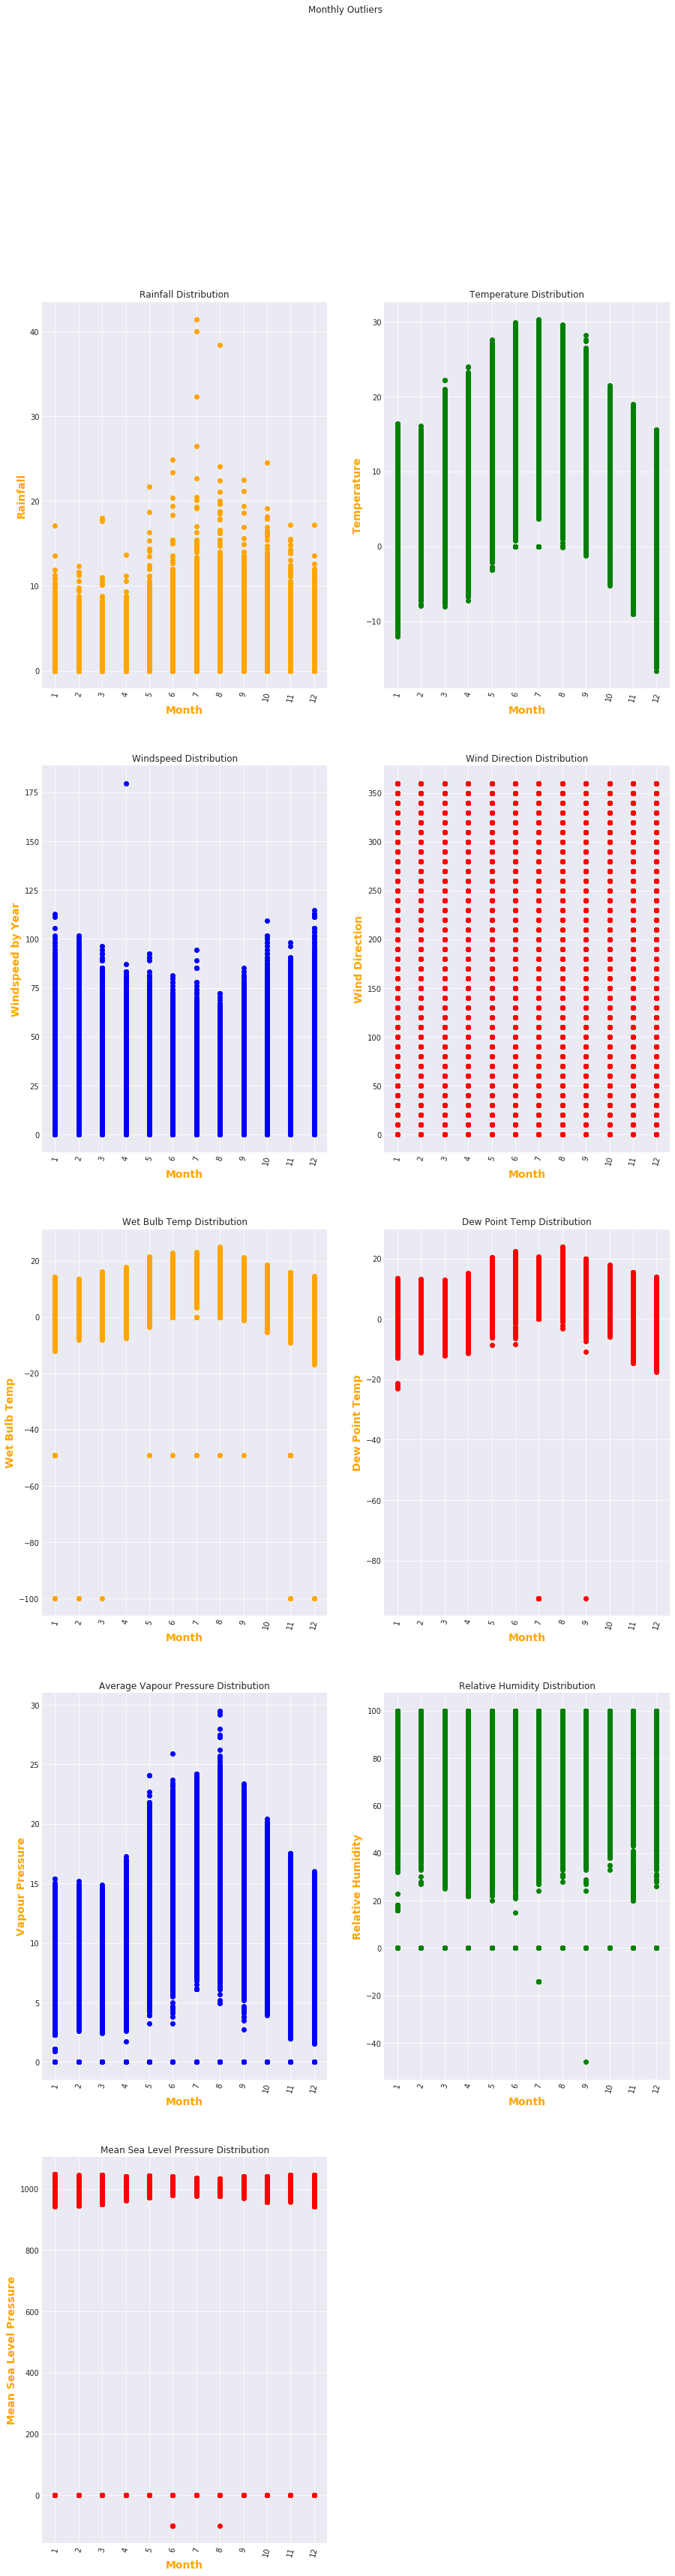

CPU times: user 4min 56s, sys: 764 ms, total: 4min 57s
Wall time: 4min 57s


In [42]:
%time outliers_by_month(data)

In [43]:
temp = data[data['rhum'] <= 0]
basic_numeric_analysis(temp)
temp['station'].value_counts()

           rain      temp      wetb     dewpt     vappr      rhum       msl  \
count 55,475.00 55,475.00 55,475.00 55,475.00 55,475.00 55,475.00 55,475.00   
mean       0.09     10.16      8.80      7.46      0.00     -0.00  1,011.42   
std        0.45      4.37      4.90      4.66      0.00      0.31     27.13   
min        0.00     -8.40    -99.90    -92.40      0.00    -48.00      0.00   
25%        0.00      7.20      6.00      4.30      0.00      0.00  1,004.20   
50%        0.00     10.20      9.00      7.70      0.00      0.00  1,013.20   
75%        0.00     13.30     11.90     10.70      0.00      0.00  1,020.90   
max       20.00     26.70     23.70     22.30      0.00      0.00  1,046.00   

           wdsp     wddir  
count 55,475.00 55,475.00  
mean      17.63    172.97  
std       14.21    113.76  
min        0.00      0.00  
25%        7.41     80.00  
50%       16.67    200.00  
75%       25.93    270.00  
max      112.97    360.00  


Roches_Point      23787
Finner            20115
Claremorris       11533
Knock_Airport        21
Moore_Park           15
Cork_Airport          2
Dublin_Airport        1
Mace_Head             1
Name: station, dtype: int64

In [44]:
temp = data[data['wetb'] <= -40]
basic_numeric_analysis(temp)
temp['station'].value_counts()

        rain   temp   wetb  dewpt  vappr   rhum      msl   wdsp  wddir
count 123.00 123.00 123.00 123.00 123.00 123.00   123.00 123.00 123.00
mean    0.05   6.35 -52.72   6.26   1.30  10.95   969.88   2.95  36.26
std     0.37   3.30  13.31   2.91   3.62  29.65   239.41   7.28  84.63
min     0.00  -5.60 -99.90   0.00   0.00   0.00     0.00   0.00   0.00
25%     0.00   5.85 -49.00   5.85   0.00   0.00 1,025.30   0.00   0.00
50%     0.00   7.20 -49.00   7.20   0.00   0.00 1,030.40   0.00   0.00
75%     0.00   7.80 -49.00   7.70   0.00   0.00 1,033.95   0.00   0.00
max     4.00  13.90 -49.00  13.30  15.30 100.00 1,039.90  37.04 350.00


Roches_Point       99
Claremorris         9
Cork_Airport        7
Shannon_Airport     4
Casement            4
Name: station, dtype: int64

In [45]:
temp = data[data['dewpt'] <= -20]
basic_numeric_analysis(temp)
temp['station'].value_counts()

       rain  temp  wetb  dewpt  vappr   rhum      msl  wdsp  wddir
count 32.00 32.00 32.00  32.00  32.00  32.00    32.00 32.00  32.00
mean   0.16  7.64  0.20 -57.24   0.51   0.38 1,017.95  9.38 225.00
std    0.47  7.59  4.42  35.73   0.52  17.79    12.68  3.15  64.76
min    0.00 -0.60 -4.70 -92.40   0.00 -48.00   998.70  3.70  10.00
25%    0.00  0.27 -4.03 -92.40   0.00 -14.00 1,005.10  7.41 190.00
50%    0.00  7.25  0.05 -57.65   0.45   1.00 1,018.45  9.26 220.00
75%    0.00 14.80  4.35 -21.90   1.00  17.00 1,030.67 11.11 272.50
max    2.50 17.50  5.90 -21.30   1.10  18.00 1,031.90 18.52 320.00


Claremorris    16
Moore_Park     15
Mace_Head       1
Name: station, dtype: int64

In [46]:
temp = data[data['msl'] < 940]
basic_numeric_analysis(temp)
temp['station'].value_counts()

           rain      temp      wetb     dewpt     vappr      rhum       msl  \
count 26,859.00 26,859.00 26,859.00 26,859.00 26,859.00 26,859.00 26,859.00   
mean       0.11      6.72      5.96      5.11      9.27     90.51     -0.02   
std        0.46      5.78      5.28      4.90      3.27     10.65      1.36   
min        0.00     -5.70    -49.00     -6.90      0.00      0.00    -99.90   
25%        0.00      0.00      0.00      0.00      6.10     87.00      0.00   
50%        0.00      6.80      6.00      4.90      8.70     93.00      0.00   
75%        0.00     11.30     10.30      9.20     11.70    100.00      0.00   
max       13.60     27.80     20.80     18.70     21.60    100.00      0.00   

           wdsp     wddir  
count 26,859.00 26,859.00  
mean      14.77    189.13  
std       10.49    100.41  
min        0.00      0.00  
25%        7.41    110.00  
50%       12.96    200.00  
75%       20.37    270.00  
max      114.82    360.00  


Mullingar        18761
Roches_Point      6368
JohnstownII        519
Claremorris        440
Newport            213
Mt_Dillon          146
Athenry            126
Oak_Park           117
SherkinIsland       47
Mace_Head           44
Ballyhaise          42
Knock_Airport       18
Dunsany             18
Name: station, dtype: int64

In [47]:
temp = data[data['vappr'] <= 0]
basic_numeric_analysis(temp)
temp['station'].value_counts()

           rain      temp      wetb     dewpt     vappr      rhum       msl  \
count 60,873.00 60,873.00 60,873.00 60,873.00 60,873.00 60,873.00 60,873.00   
mean       0.08     10.31      8.94      7.59      0.00      7.37  1,011.47   
std        0.43      4.37      4.84      4.65      0.00     23.87     26.08   
min        0.00     -8.40    -99.90    -92.40      0.00    -48.00      0.00   
25%        0.00      7.30      6.10      4.40      0.00      0.00  1,004.40   
50%        0.00     10.40      9.20      7.90      0.00      0.00  1,013.30   
75%        0.00     13.50     12.10     10.80      0.00      0.00  1,020.70   
max       20.00     27.60     23.70     22.30      0.00    100.00  1,046.00   

           wdsp     wddir  
count 60,873.00 60,873.00  
mean      17.80    174.55  
std       13.95    111.90  
min        0.00      0.00  
25%        7.41     90.00  
50%       16.67    200.00  
75%       25.93    270.00  
max      112.97    360.00  


Finner            25489
Roches_Point      23792
Claremorris       11533
Moore_Park           33
Knock_Airport        21
Cork_Airport          2
JohnstownII           1
Dublin_Airport        1
Mace_Head             1
Name: station, dtype: int64

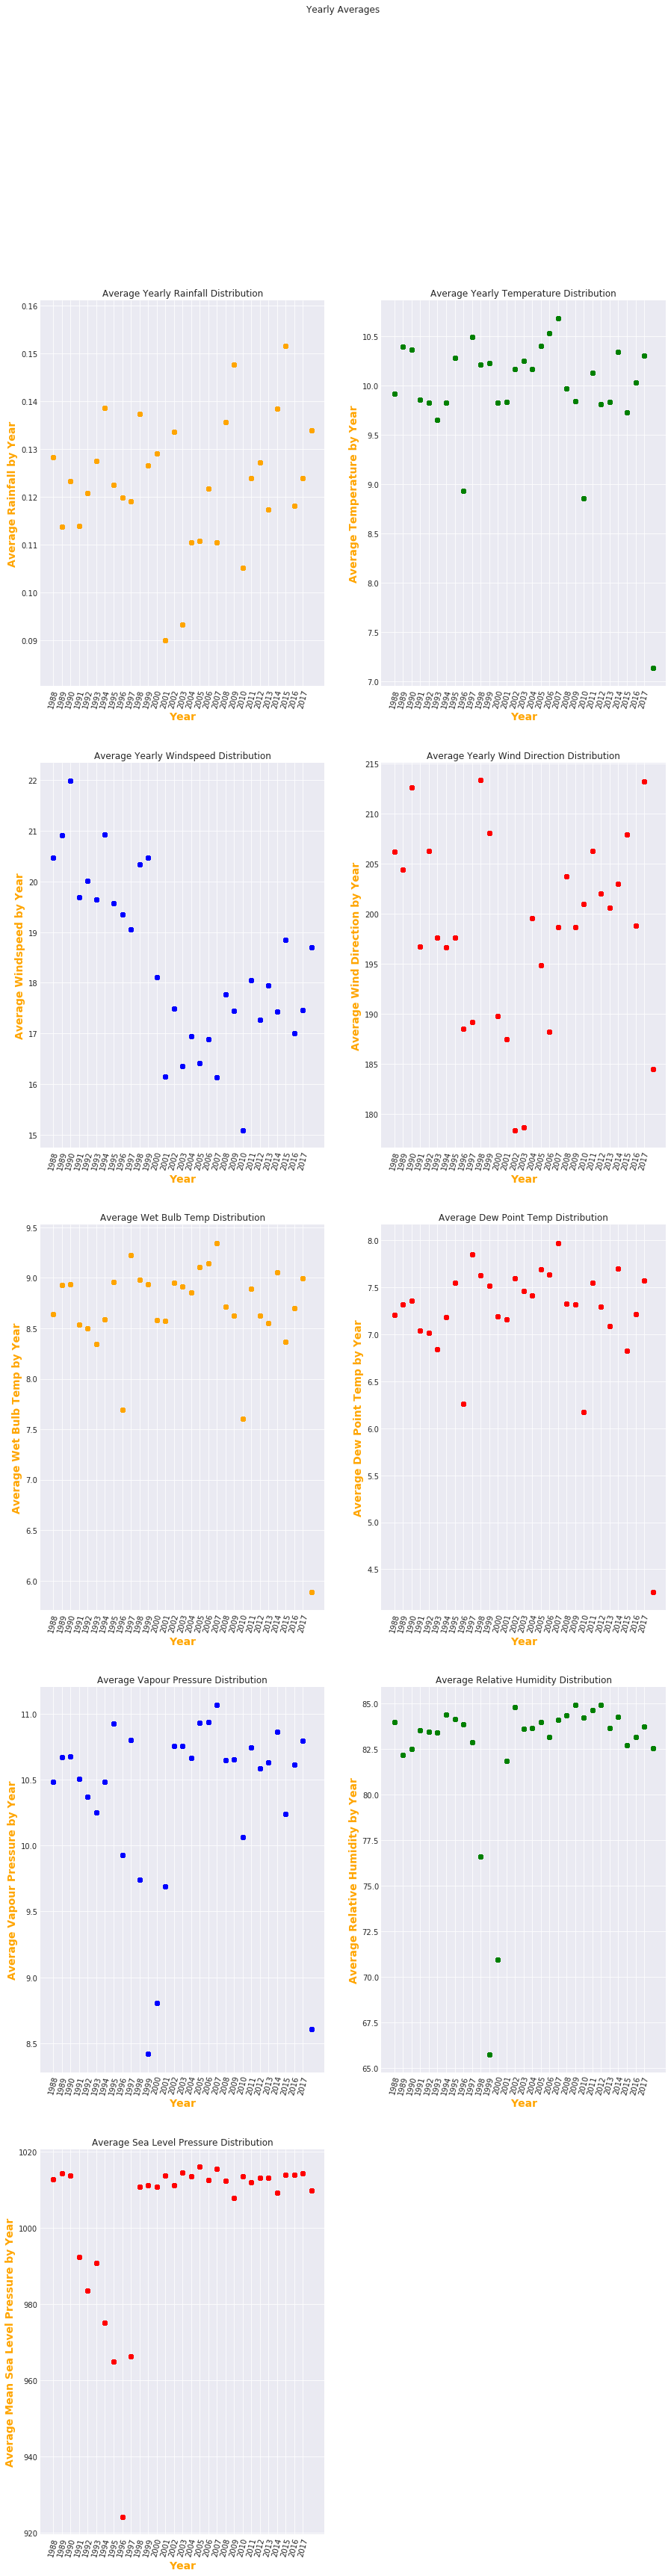

CPU times: user 4min 54s, sys: 736 ms, total: 4min 55s
Wall time: 4min 55s


In [48]:
%time plot_by_year(data)

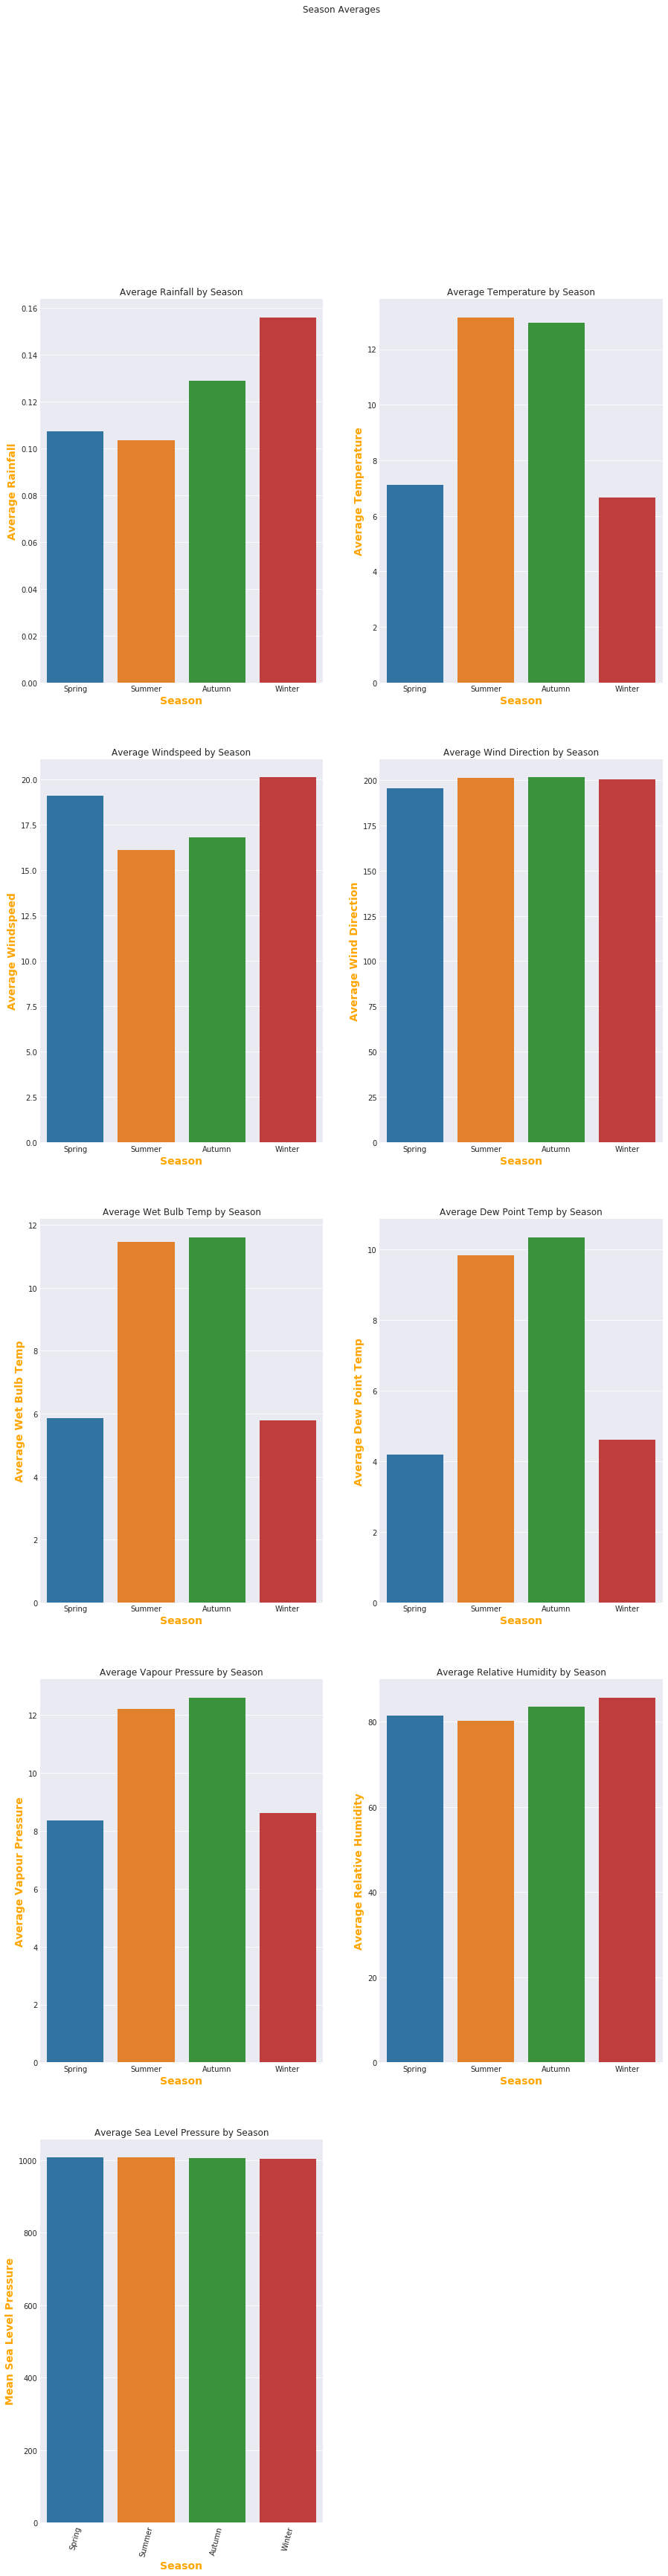

CPU times: user 6min 12s, sys: 752 ms, total: 6min 13s
Wall time: 6min 13s


In [49]:
%time plot_by_season(data)

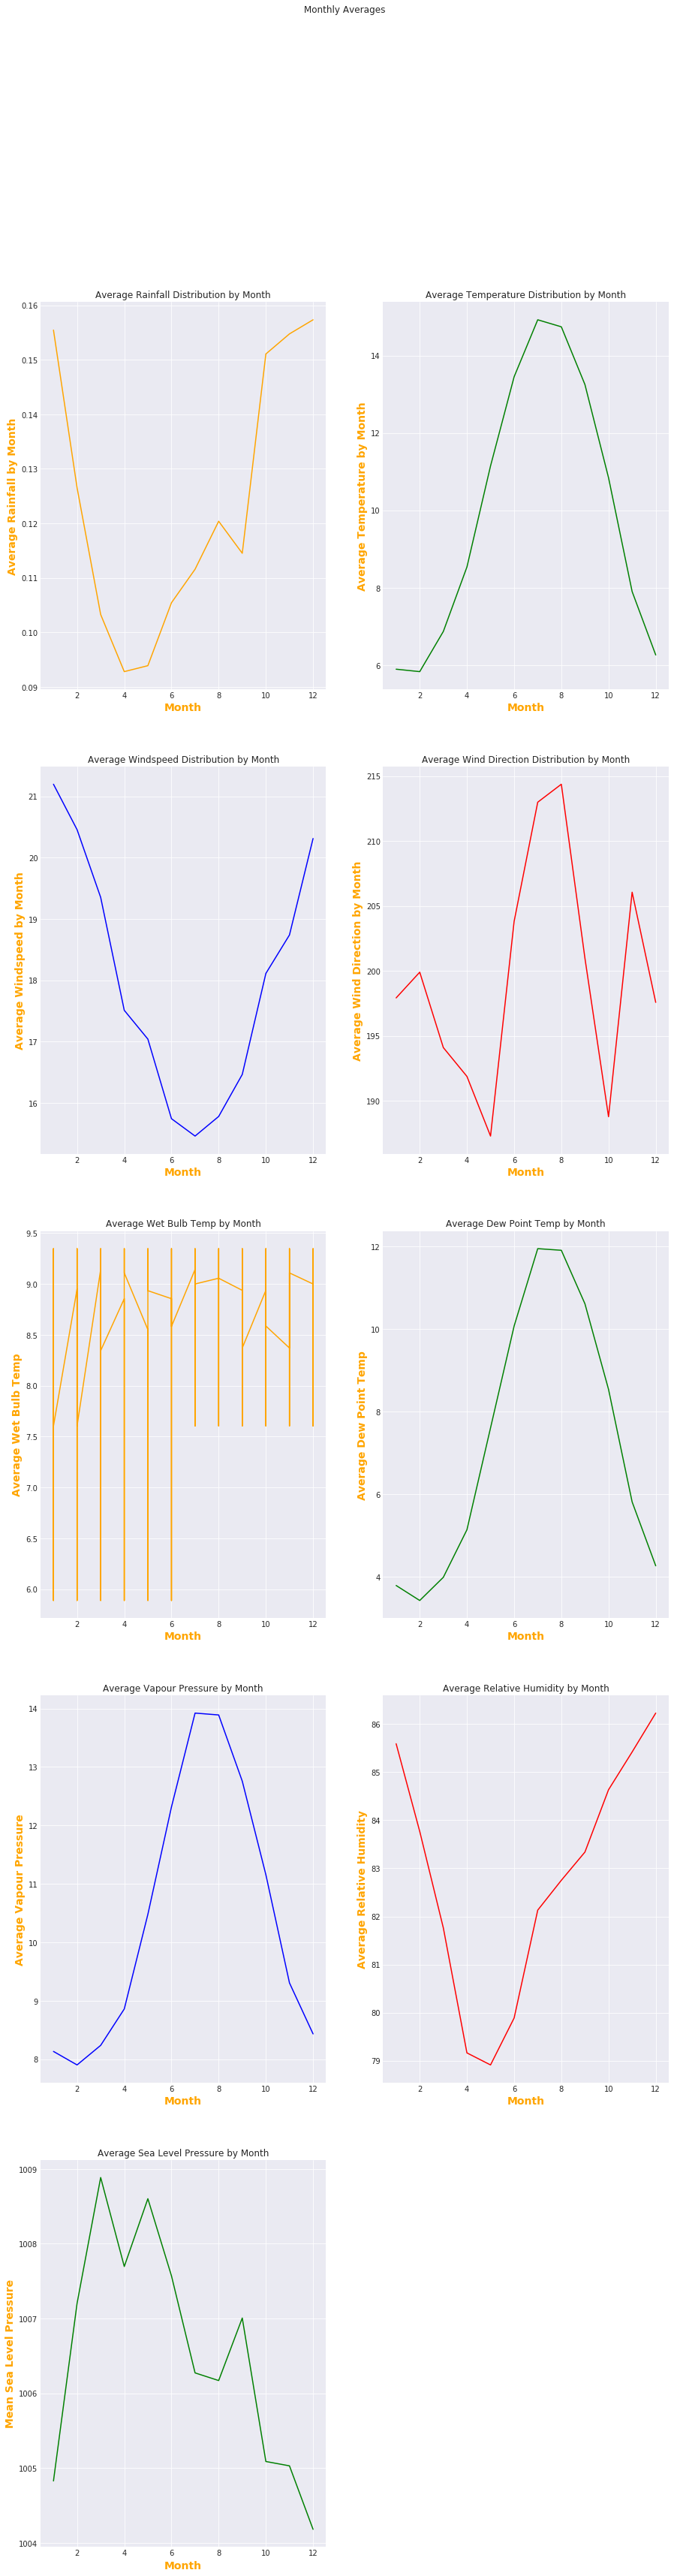

CPU times: user 8.48 s, sys: 1.02 s, total: 9.49 s
Wall time: 9.5 s


In [50]:
%time plot_by_month(data)

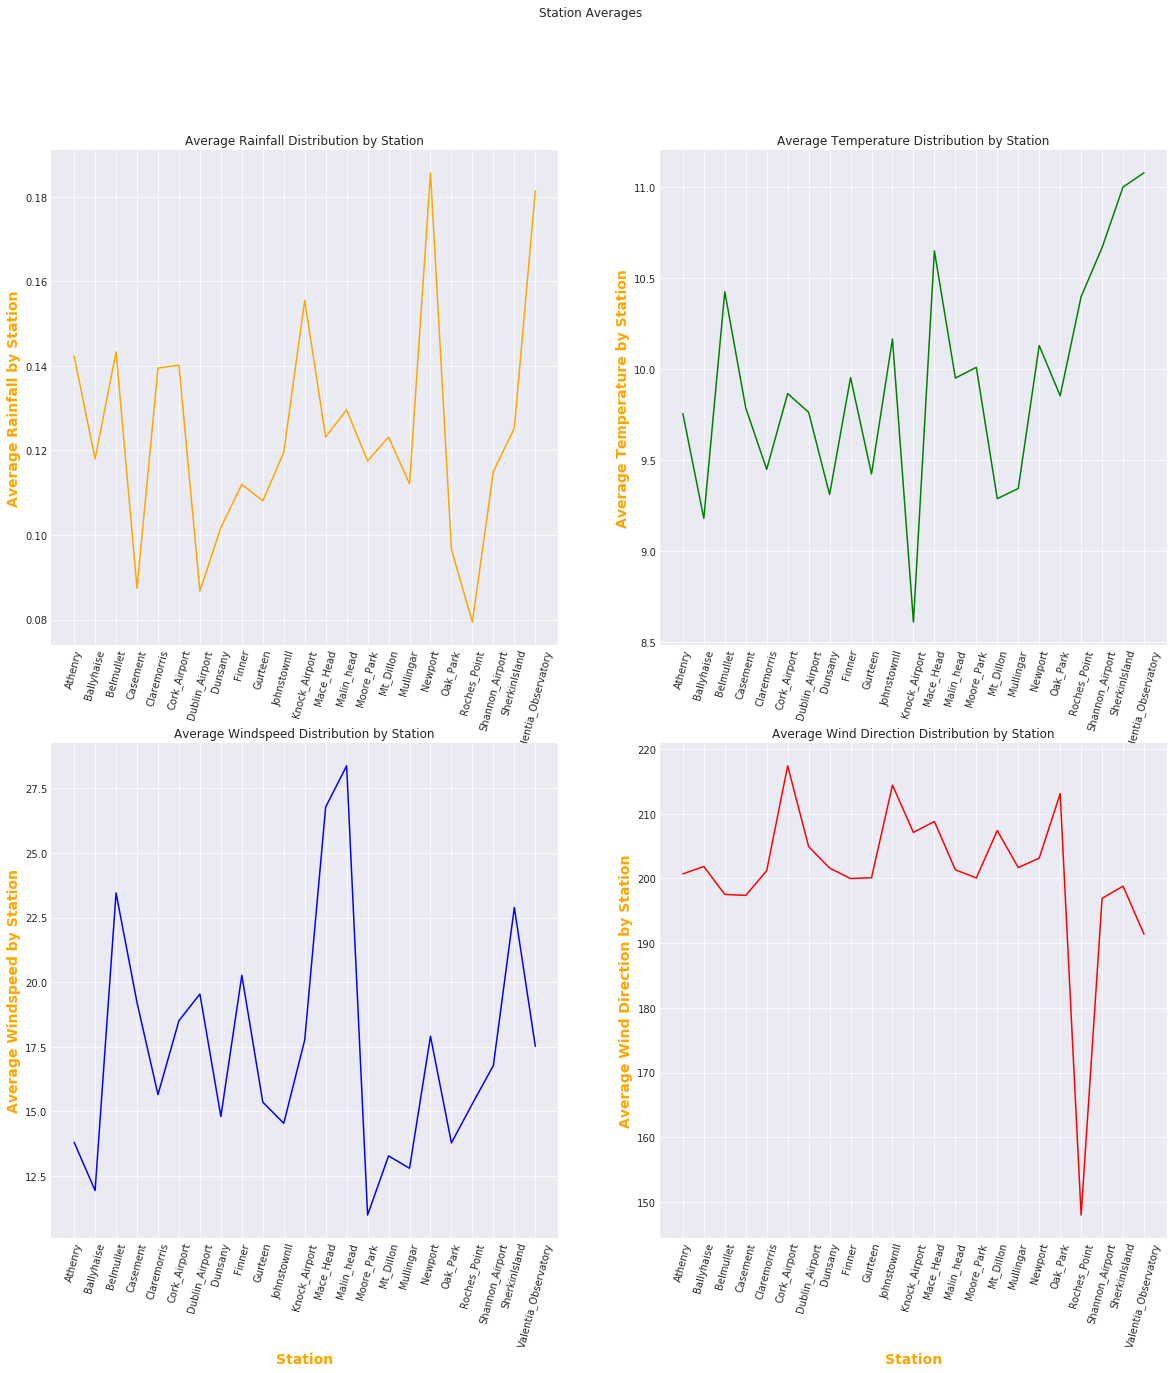

CPU times: user 3min 2s, sys: 3.7 s, total: 3min 5s
Wall time: 3min 5s


In [51]:
%time plot_by_station(data)

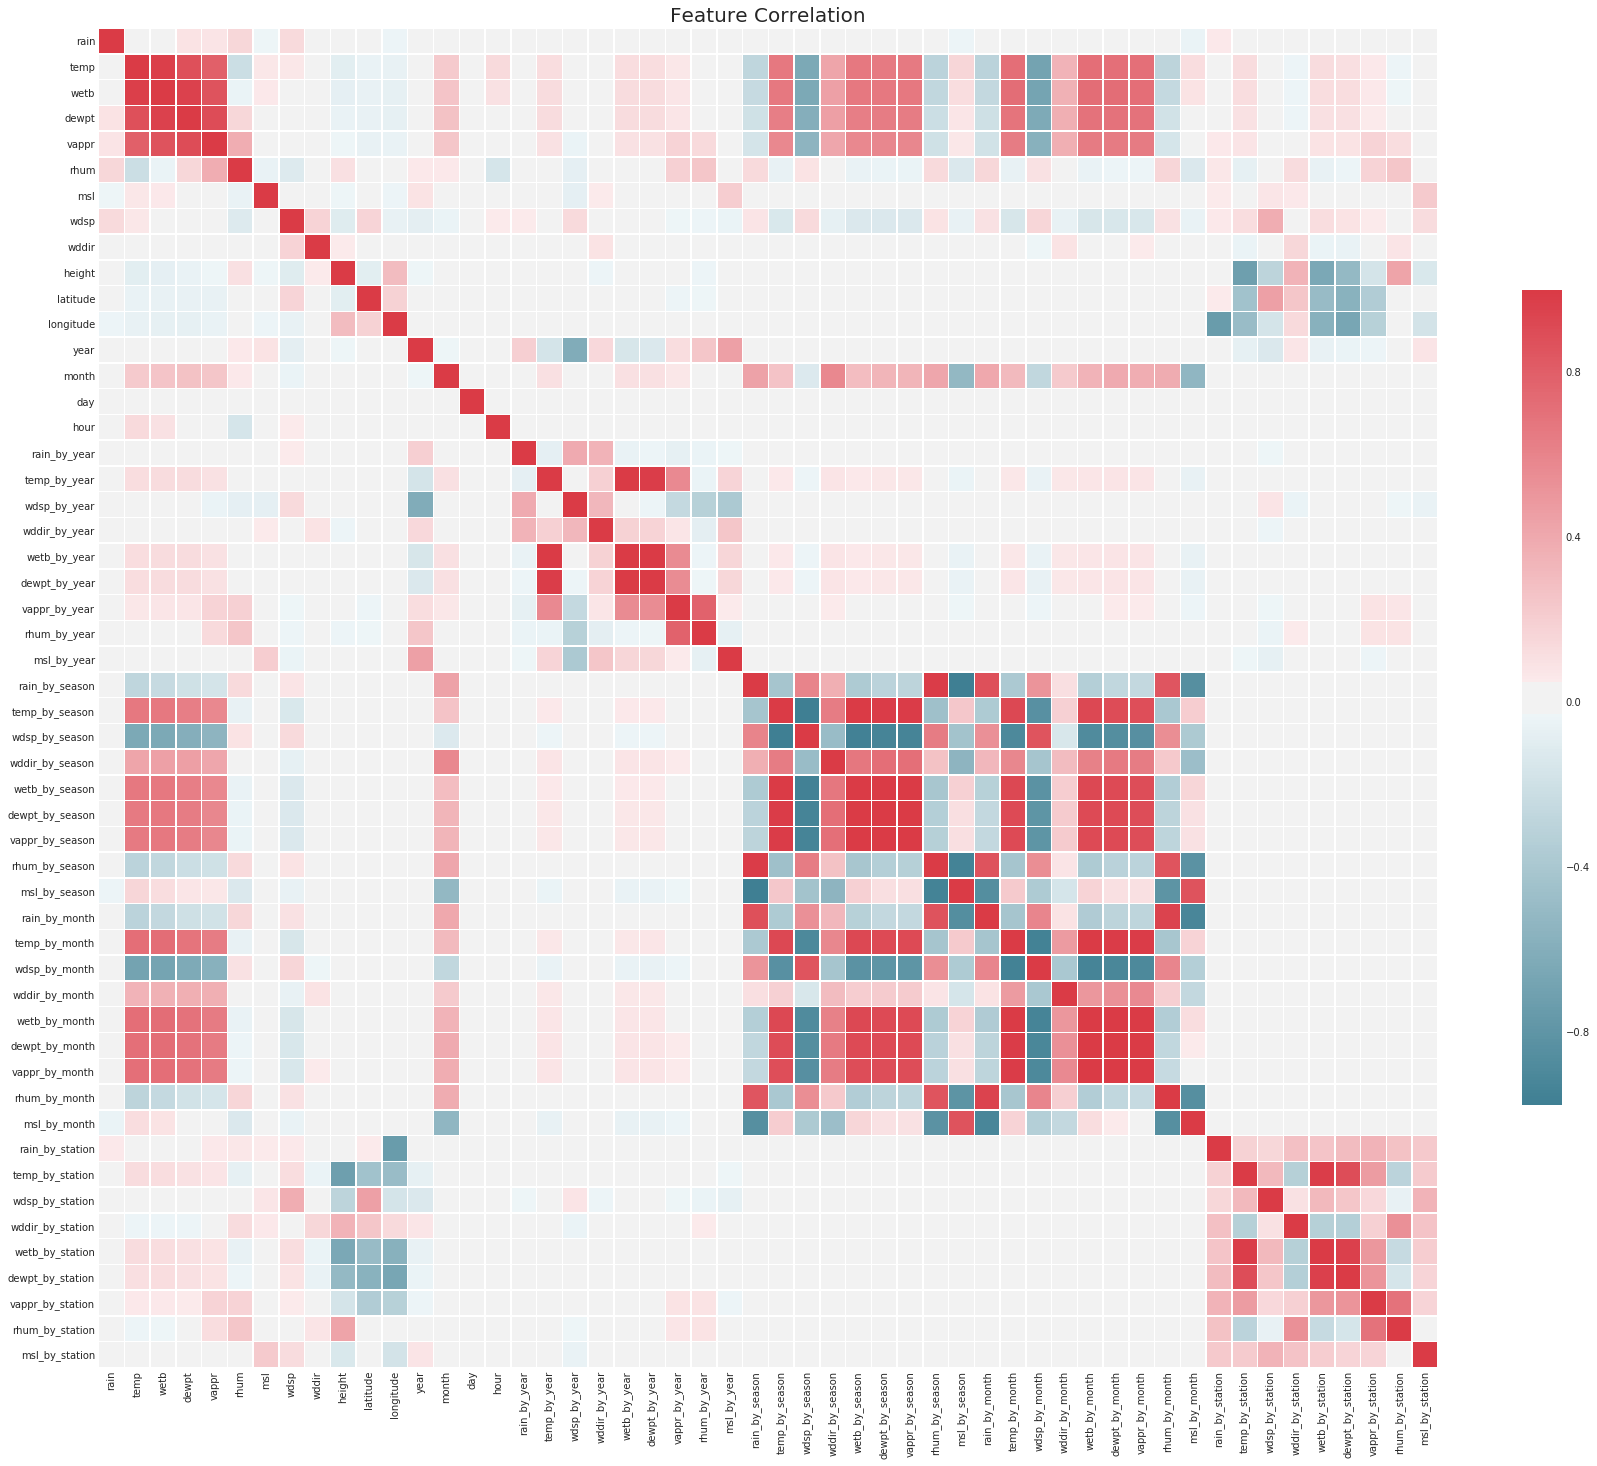

CPU times: user 17.9 s, sys: 432 ms, total: 18.4 s
Wall time: 18.4 s


In [52]:
%time display_feature_correlations(data)

In [53]:
data = select_data()
data = change_structure(data)
data = split_time(data)
data = generate_season(data)
data = convert_wdsp(data)

data = update_rhum_values(data)
data = update_wetb_values(data)
data = update_dewpt_values(data)
data = update_msl_values(data)
data = update_vappr_values(data)
print('')

#%time display_feature_correlations(data)

Extracting Data
Extracted Data
date         0
rain         0
temp         0
wetb         0
dewpt        0
vappr        0
rhum         0
msl          0
wdsp         0
wddir        0
height       0
latitude     0
longitude    0
station      0
county       0
dtype: int64
Updating relative humidity values <= 0
Updating wet bulb air temperature values <= 0
Updating dew point air temperature values <= 0
Updating mean sea level pressure values <= 0
Updating vapour pressure values <= 0



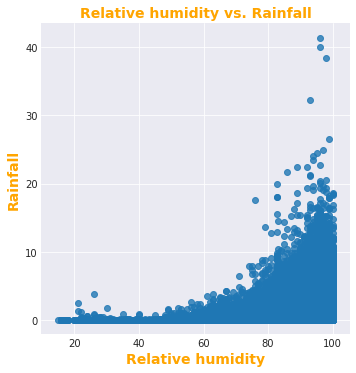

CPU times: user 41.7 s, sys: 160 ms, total: 41.9 s
Wall time: 41.8 s


In [54]:
%time rhum_vs_rain(data)

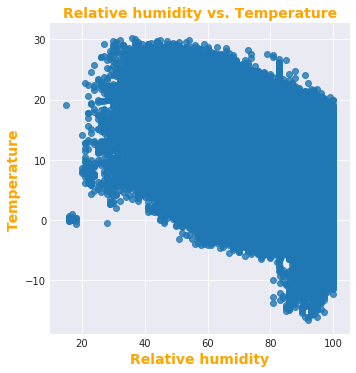

CPU times: user 41.7 s, sys: 136 ms, total: 41.8 s
Wall time: 41.8 s


In [55]:
%time rhum_vs_temp(data)

# Seasonal statistics based on hourly data

In [56]:
seasonal_statistics(data)

************ Winter Statistics *************

              rain         temp         wetb        dewpt        vappr  \
count 1,014,986.00 1,014,986.00 1,014,986.00 1,014,986.00 1,014,986.00   
mean          0.16         6.66         5.79         4.60         8.76   
std           0.52         3.60         3.49         3.73         2.25   
min           0.00       -16.60       -16.80       -17.50         0.90   
25%           0.00         4.30         3.50         1.90         7.00   
50%           0.00         7.00         5.90         4.50         8.50   
75%           0.00         9.30         8.40         7.40        10.40   
max          17.20        19.00        15.90        15.40        17.50   

              rhum          msl         wdsp        wddir  
count 1,014,986.00 1,014,986.00 1,014,986.00 1,014,986.00  
mean         86.95     1,011.54        20.11       200.43  
std           9.03        15.35        13.24        85.44  
min          16.00       942.80         0.00   